In [2]:
%load_ext autoreload
%autoreload 2

import PIL.Image
import cv2
from math import floor
import numpy as np
import os
import matplotlib.pyplot as plt
from recognition_functions import *
from plot_helper import *

from collections import Counter

path_data = "data/train"
path_setup = "data/image_setup/"

In [3]:
from table_extractor import TableExtractor
from card_extractor import CardExtractor

### Read images

In [4]:
images = []

for i in range(28):
    #if i not in problematic_imgs:
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    im = PIL.Image.open(file)
    images.append(np.array(im))

### Extract table

In [5]:
table_imgs = []
for img in images:
    table_img = TableExtractor.extract_table(img,plot=False)
    table_imgs.append(table_img)

### Partition image

In [6]:
partitions = []
for table_img in table_imgs:
    partition = partition_image(table_img)
    partitions.append(partition)

In [7]:
cards_pair_imgs = []
for p in partitions:
    cards_pair_imgs.append(np.rot90(p['left_cards']))
    cards_pair_imgs.append(np.rot90(p['top_left_cards'], 2))
    cards_pair_imgs.append(np.rot90(p['top_right_cards'], 2))
    cards_pair_imgs.append(np.rot90(p['right_cards'], 3))

0


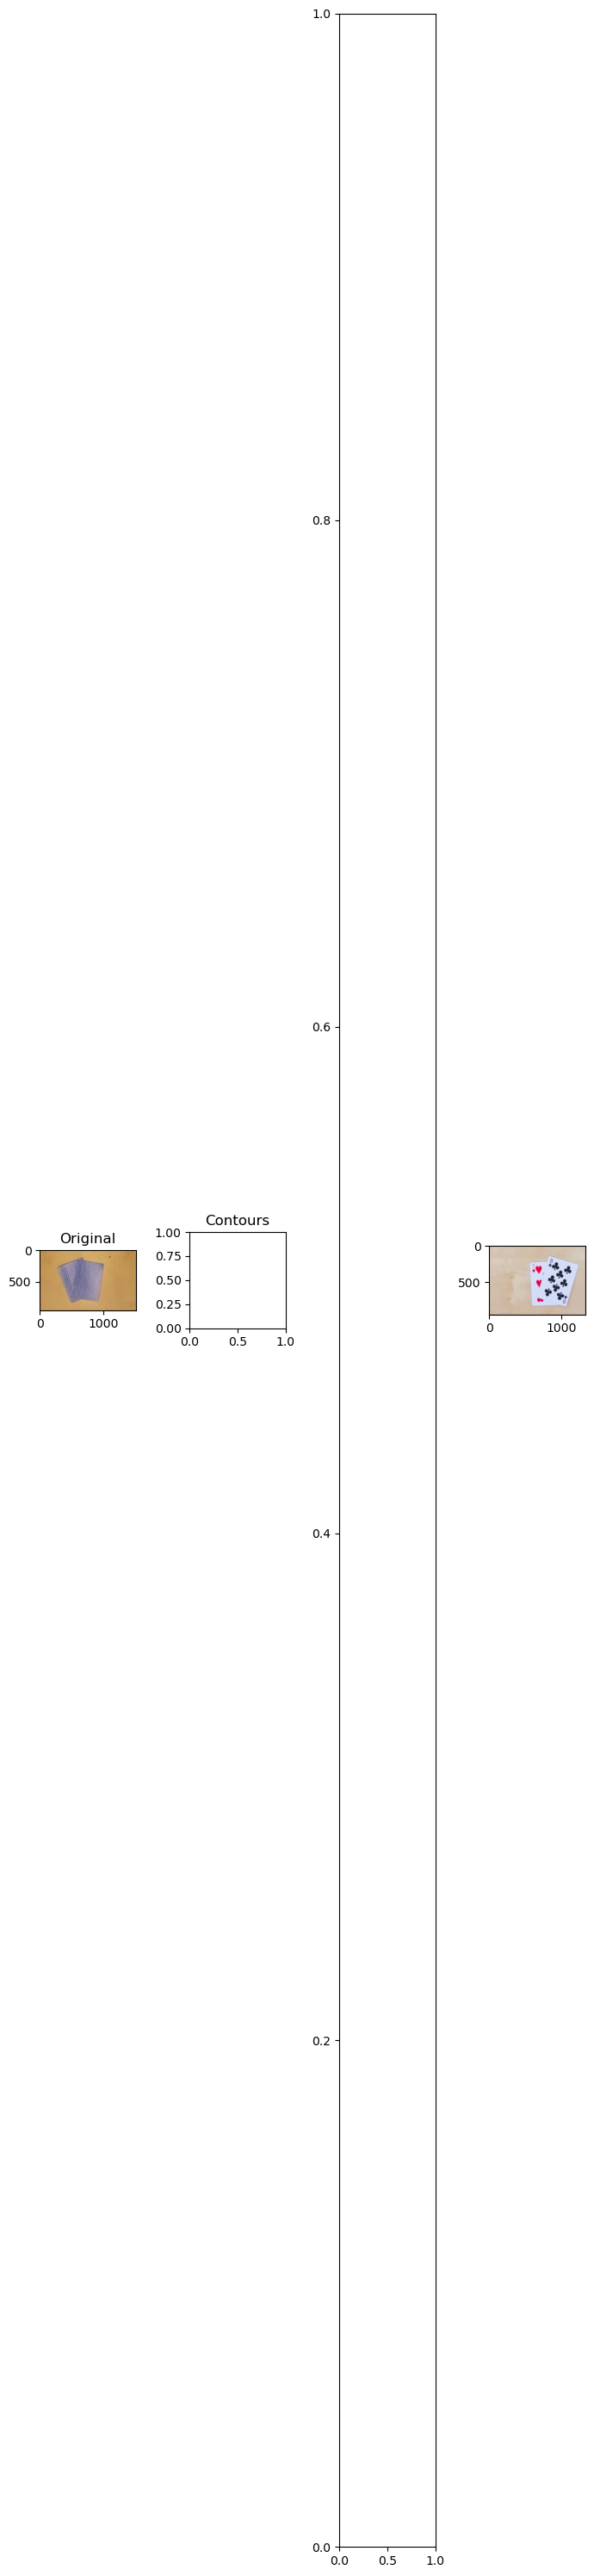

1


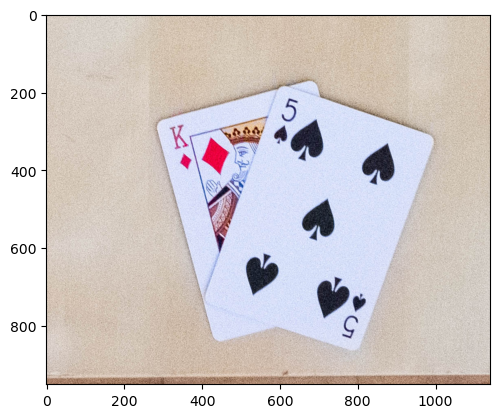

2


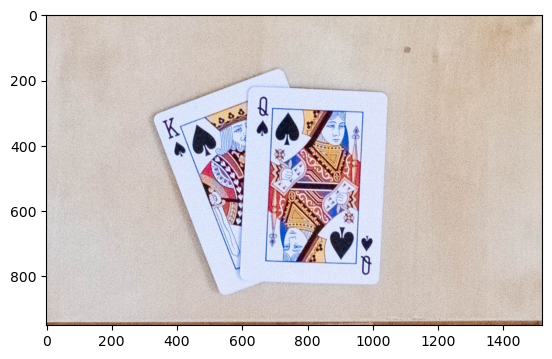

3


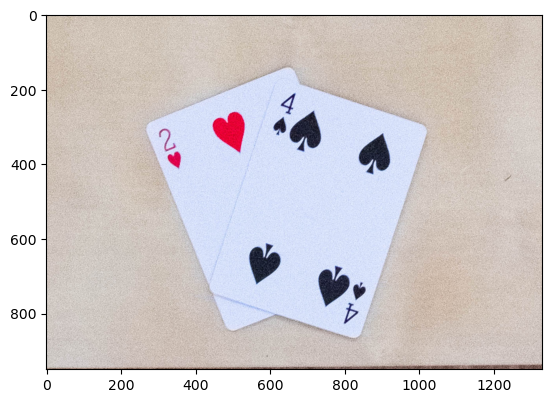

4


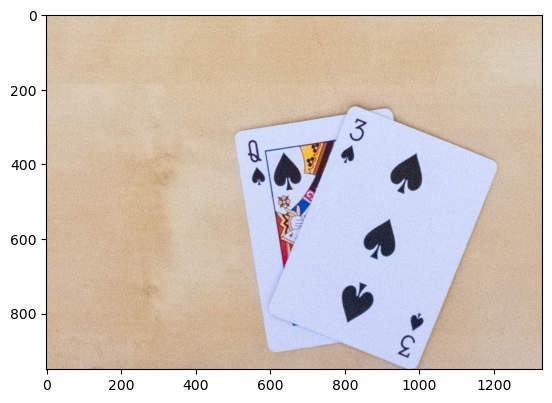

5


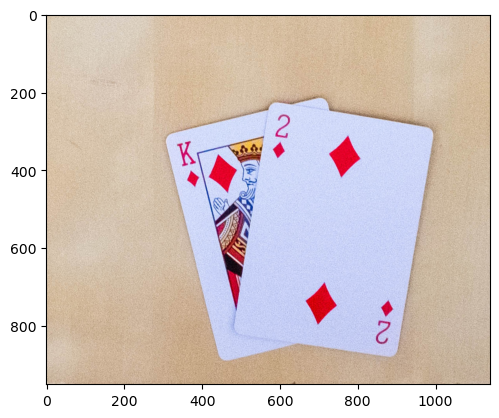

6


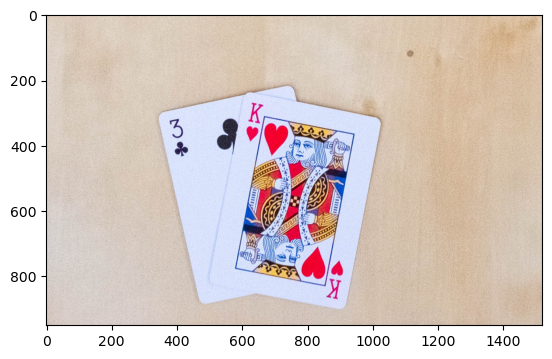

7


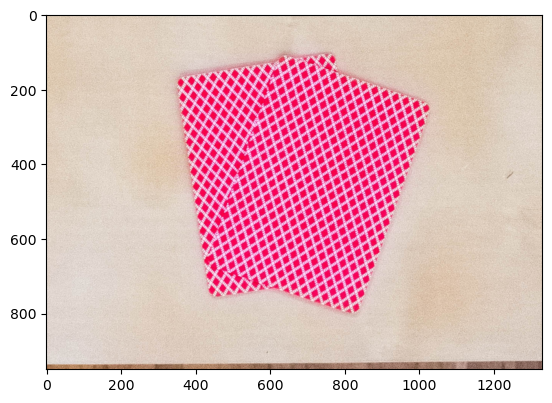

8


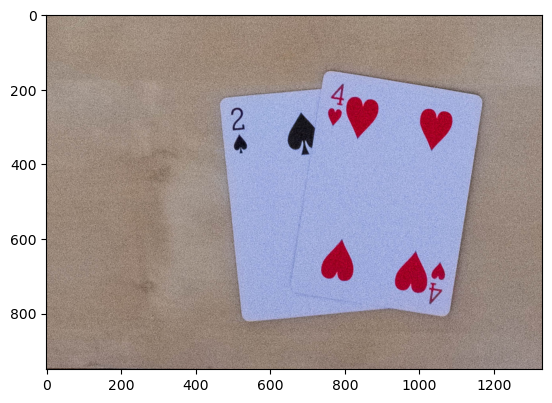

9


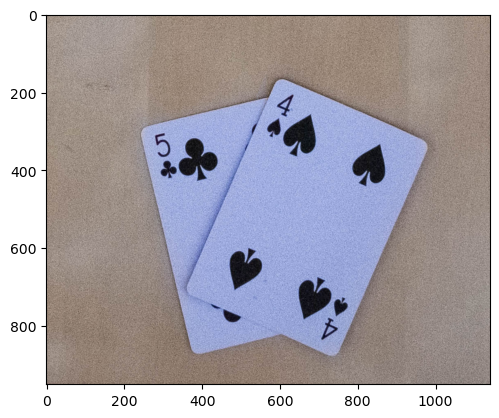

10


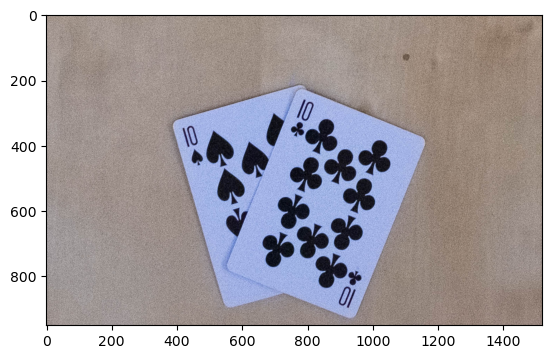

11


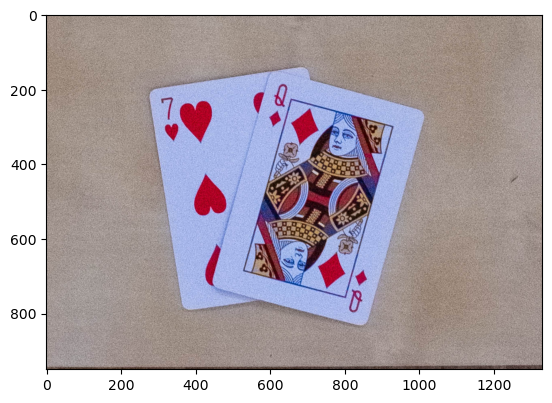

12


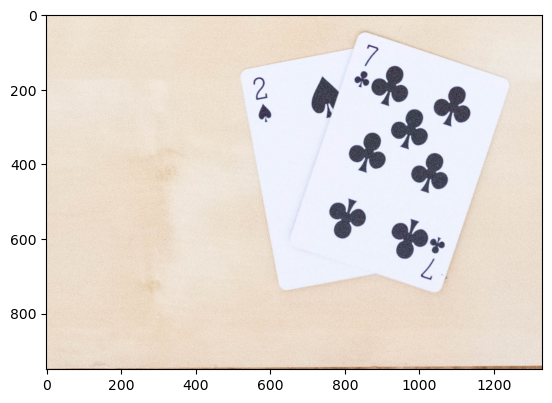

13


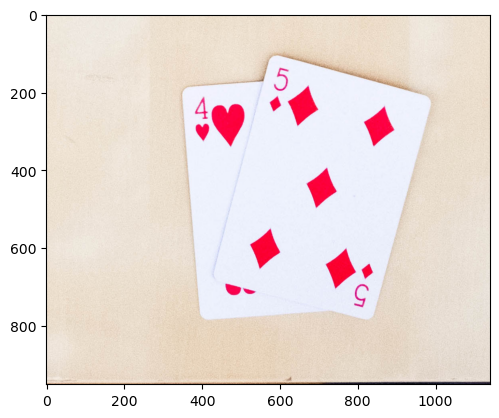

14


KeyboardInterrupt: 

In [31]:
for i, c in enumerate(cards_pair_imgs):
    print(i)
    plt.imshow(c)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


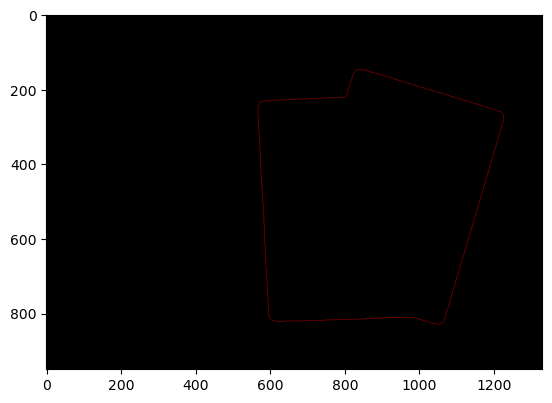

In [8]:
p = partitions[0]
c = p['left_cards']
card = np.rot90(c)

candidate_contours = extract_candidate_contours(card,shape_count = 1,n_thresholds=2,plot=False)
img_area = card.shape[0]*card.shape[1]
best_contour = choose_best_pair_contour(candidate_contours, img_area)



img = cv2.drawContours(np.zeros(card.shape), best_contour, -1,(255,0,0),1)
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 2)
[575 235]
[602 817]
[983 811]
[1064  825]
[1223  265]
[847 148]
[826 154]
[801 222]


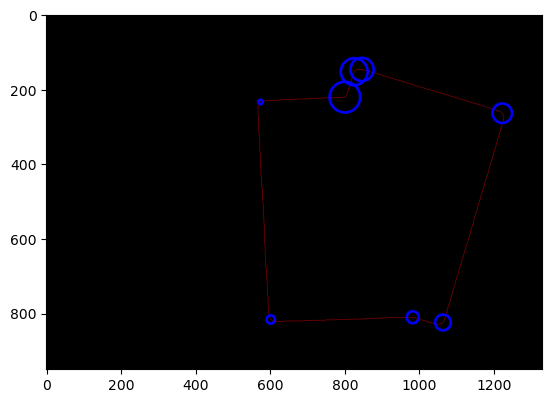

In [9]:
peri = cv2.arcLength(best_contour,False)
approx_vertices = cv2.approxPolyDP(best_contour,0.005 *peri,True)[:,0]

approx_img = img.copy()
print(approx_vertices.shape)

r = 1
for v in approx_vertices:
    r+= 5
    print(v)
    cv2.circle(approx_img, v, radius=r, color=(0, 0, 255), thickness=5)

plt.imshow(approx_img)
plt.show()

In [50]:
card_size = [300,400]

card_height = []

from recognition_functions import reorder_corners

HEIGHT_CARD = 582
WIDTH_CARD = 400

def perpendicular_unity_vector_2d(v):
    per = [v[1], - v[0]]
    return per / np.linalg.norm(per)



def add_margin(corners):
    HEIGHT_CARD_MARGIN_PIX = 10
    WIDTH_CARD_MARGIN_PIX = 10
    
    down_height_vec = corners[3] - corners[0]
    down_height_margin_vec =  down_height_vec / np.linalg.norm(down_height_vec) * HEIGHT_CARD_MARGIN_PIX
    
    right_width_vec = corners[1] - corners[0]
    right_width_margin_vec =  right_width_vec / np.linalg.norm(right_width_vec) * WIDTH_CARD_MARGIN_PIX

    new_corners = []
    new_corners.append(list(corners[0] - down_height_margin_vec - right_width_margin_vec)) # top left - down - right
    new_corners.append(list(corners[1] - down_height_margin_vec + right_width_margin_vec)) # top right - down + right
    new_corners.append(list(corners[2] + down_height_margin_vec + right_width_margin_vec)) # bottom right + down + right
    new_corners.append(list(corners[3] + down_height_margin_vec - right_width_margin_vec)) # bottom left + down - right
    
    return new_corners

    

def extract_card_from_two_corners_height(img, pot_corner_1, pot_corner_2, approx_vertices):
    
    corner_1_2_vect = pot_corner_2 - pot_corner_1

    # Find third corner along the width
    per_vec = perpendicular_unity_vector_2d(corner_1_2_vect) * WIDTH_CARD
    mean_pts = approx_vertices.mean(axis = 0)

    is_card_on_top = mean_pts[0] < max(pot_corner_1[0], pot_corner_2[0])
    # Choose direction of per_vec toward center of points along x axis

    if is_card_on_top:
        if per_vec[0] > 0:
            per_vec = per_vec * -1
    else:
        if per_vec[0] < 0:
            per_vec = per_vec * -1

    pot_corner_3 = pot_corner_1 + per_vec
    pot_corner_4 = pot_corner_2 + per_vec

    corners = reorder_corners(np.array([pot_corner_1, pot_corner_2, pot_corner_3, pot_corner_4]))
    corners = np.array(add_margin(corners))
  

    h = np.array([[0,0],[card_size[0],0],[card_size[0],card_size[1]],[0,card_size[1]] ],np.float32)

    transform = cv2.getPerspectiveTransform(corners, h)
    extracted_card = cv2.warpPerspective(img,transform,card_size)
    
    return extracted_card, is_card_on_top

def extract_card_from_two_corners_width(img, pot_corner_1, pot_corner_2, approx_vertices):
        
    width_vec = pot_corner_2 - pot_corner_1

    # Find third corner along the height
    height_vec = perpendicular_unity_vector_2d(width_vec) * HEIGHT_CARD
    mean_pts = approx_vertices.mean(axis = 0)

    is_card_on_top = mean_pts[0] < max(pot_corner_1[0], pot_corner_2[0])
    # Choose direction of per_vec toward center of points along x axis

    if is_card_on_top:
        if per_vec[0] > 0:
            per_vec = per_vec * -1
    else:
        if per_vec[0] < 0:
            per_vec = per_vec * -1

    pot_corner_3 = pot_corner_1 + per_vec
    pot_corner_4 = pot_corner_2 + per_vec

    corners = reorder_corners(np.array([pot_corner_1, pot_corner_2, pot_corner_3, pot_corner_4]))
    corners = np.array(add_margin(corners))
  

    h = np.array([[0,0],[card_size[0],0],[card_size[0],card_size[1]],[0,card_size[1]] ],np.float32)

    transform = cv2.getPerspectiveTransform(corners, h)
    extracted_card = cv2.warpPerspective(img,transform,card_size)
    
    return extracted_card, is_card_on_top

def extract_pair_cards(cards_img, plot=False):
    """
    Return first card on the bottom then card on the top
    """
    
    ACCEPTED_HEIGHT_DELTA = HEIGHT_CARD * 0.05
    ACCEPTED_WIDTH_DELTA = WIDTH_CARD * 0.05
    APPROX_CONTOUR = 0.008
    
    # Extract contour
    candidate_contours = extract_candidate_contours(cards_img,shape_count = 1,n_thresholds=2,plot=False)
    img_area = cards_img.shape[0]*cards_img.shape[1]
    best_contour = choose_best_pair_contour(candidate_contours, img_area)
    
    peri = cv2.arcLength(best_contour,False)
    approx_vertices = cv2.approxPolyDP(best_contour, APPROX_CONTOUR *peri,True)[:,0]
    
    diff = []

    # Distance between two consecutive points
    for i in range(approx_vertices.shape[0]):
        diff.append(np.linalg.norm(approx_vertices[i]-approx_vertices[i-1]))
    diff = np.array(diff)

    distance_to_height = np.abs(diff - 582)

    # TODO do a ranking a test multiple one

    min_dist_idx = np.argsort(distance_to_height)

    top_card = None
    bottom_card = None
    for idx in min_dist_idx:
        if distance_to_height[idx] < ACCEPTED_HEIGHT_DELTA:
            idx_card_width_1 = idx
            idx_card_width_2 = idx_card_width_1 - 1

            pot_corner_1 = approx_vertices[idx_card_width_1]
            pot_corner_2 = approx_vertices[idx_card_width_2]

            extracted_card, is_card_on_top = extract_card_from_two_corners_height(cards_img, pot_corner_1, pot_corner_2, approx_vertices)
            
            if is_card_on_top:
                top_card = extracted_card
            else : 
                bottom_card = extracted_card
        
    if plot:
        fig, axes = plt.subplots(1, 5, figsize=(7, 30),tight_layout=True)
        axes[0].set_title(f"Original")
        axes[0].imshow(cards_img)
        contours_img = cv2.drawContours(np.zeros(cards_img.shape), best_contour, -1,(255,0,0),20)
        
        
        for v in approx_vertices:
            cv2.circle(contours_img, v, radius=10, color=(0, 255, 0), thickness=15)
        axes[1].set_title(f"Contours")
        axes[1].imshow(contours_img)
        for v in approx_vertices:
            cv2.circle(contours_img, v, radius=10, color=(0, 255, 0), thickness=15)
        axes[1].set_title(f"Contours")
        axes[1].imshow(contours_img)
        if(type(bottom_card) != type(None)):
            axes[3].set_title(f"Bottom")
            axes[3].imshow(bottom_card)
        else:
            axes[3].set_title(f"No succes")
            axes[3].imshow(np.zeros(card_size))
        
        if(type(top_card) != type(None)):
            axes[4].set_title(f"Top")
            axes[4].imshow(top_card)
        else:
            axes[4].set_title(f"No succes")
            axes[4].imshow(np.zeros(card_size))


        plt.show()
                
    return bottom_card, top_card
    
    

In [52]:
for i, c in enumerate(cards_pair_imgs):
    print(i)
    ex_cards = extract_pair_cards(c, False)
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


In [53]:
np.array(card_height).mean()

582.3641417635208

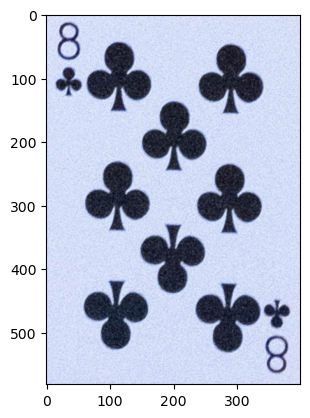

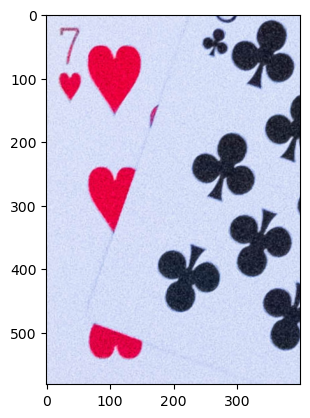

In [39]:





diff = []

# Distance between two consecutive points
for i in range(approx_vertices.shape[0]):
    diff.append(np.linalg.norm(approx_vertices[i]-approx_vertices[i-1]))
diff = np.array(diff)

distance_to_height = np.abs(diff - 582)

# TODO do a ranking a test multiple one

min_dist_idx = np.argsort(distance_to_height)

extracted_cards = []
is_top_card_extracted = False
is_bottom_card_extracted = False
for idx in min_dist_idx:
    if distance_to_height[idx] < ACCEPTED_HEIGHT_DELTA:
        idx_card_width_1 = idx
        idx_card_width_2 = idx_card_width_1 - 1

        pot_corner_1 = approx_vertices[idx_card_width_1]
        pot_corner_2 = approx_vertices[idx_card_width_2]

        extracted_card, is_card_on_top = extract_card_from_two_corners_height(pot_corner_1, pot_corner_2, approx_vertices)
        
        is_top_card_extracted |= is_card_on_top
        is_bottom_card_extracted |= not is_card_on_top
        extracted_cards.append(extracted_card)
        

for c in extracted_cards:
    plt.imshow(c)
    plt.show() 

    


In [ ]:
p = 3
x = approx_vertices[4] - approx_vertices[5] 
pnorm = np.sum(np.abs(x)**p)**(1/p)
pnorm

In [ ]:
np.linalg.norm(x)

In [ ]:
# size card => 
# h = 582 | 582
# w = >~380 | 394

In [ ]:
np.abs(approx_vertices[r] - approx_vertices[1])

In [ ]:
# Detect main lines
lines = cv2.HoughLines(img[:,:,0], 10, np.pi / 10, 70, None, 0, 0)

# Convert lines represetation
lines_pts = LineHelper.convert_hough_lines_to_point_lines(lines)

# Find all intersections points within the image
intersection_pts = LineHelper.compute_intersection_points_in_img(lines_pts, img.shape)

debug_img = img.copy()
for pt1, pt2 in lines_pts:
    LineHelper.draw_line(debug_img, pt1, pt2)

for pts in intersection_pts:
    cv2.circle(debug_img, pts, radius=13, color=(255, 255, 255), thickness=5)

plt.imshow(debug_img)
plt.show()

In [ ]:
from table_extractor import LineHelper

# Image preprocessing
gray = cv2.cvtColor(card,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(7,7),0) 
flag, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU)
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel= np.ones((11,11), np.uint8))

plt.imshow(blur)
plt.show()


# Edge detection
edges = cv2.Canny(blur, 50, 50, None, 3)

plt.imshow(edges)
plt.show()

# Detect main lines
lines = cv2.HoughLines(edges, 1, np.pi / 180, 100, None, 0, 0)

# Convert lines represetation
lines_pts = LineHelper.convert_hough_lines_to_point_lines(lines)

# Find all intersections points within the image
intersection_pts = LineHelper.compute_intersection_points_in_img(lines_pts, img.shape)

debug_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
for pt1, pt2 in lines_pts:
    LineHelper.draw_line(debug_img, pt1, pt2)

for pts in intersection_pts:
    cv2.circle(debug_img, pts, radius=13, color=(255, 255, 255), thickness=5)

plt.imshow(debug_img)
plt.show()

In [ ]:
for p in partitions:
    card = p['left_cards']

    gray = cv2.cvtColor(card,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (7, 7), 0)

    test_2 = (blur[:,:] > 210)


    #flag, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    plt.imshow(test_2)
    plt.show()

In [ ]:
p = partitions[0]
card = p['left_cards']
card.shape

In [ ]:
test = (card[:,:,0] > 200) & (card[:,:,1] > 200) & (card[:,:,2] > 200)

In [ ]:
gray = cv2.cvtColor(card,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7, 7), 0)

test_2 = (blur[:,:] > 210)


flag, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
plt.imshow(test_2)
plt.show()

In [ ]:
plt.imshow(card)
plt.show()

In [ ]:
connectivity = 4
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(card, connectivity)

In [ ]:
candidate_contours_left_images = []
for partition in partitions:
    left_cards = partition['left_cards']
    candidate_contours = extract_candidate_contours(left_cards,shape_count = 1,n_thresholds=2,plot=True)
    candidate_contours_left_images.append(candidate_contours)
    plt.show()